---
title: "AVHRR Level 1B Metop Global - Data Access"
subtitle: "This notebook demonstrates how to search and access Metop data using HDA and how to read, process and visualize it using satpy."
author: "Serena Avolio (EUMETSAT/Starion)"
tags: [HDA, Metop, AVHRR, satpy]
thumbnail: ../../img/EUMETSAT-icon.png
license: MIT
copyright: "© 2025 EUMETSAT"
---
<div style="margin: 6px 0;">
  <a href="https://jupyter.central.data.destination-earth.eu/user-redirect/lab/tree/DestinE-DataLake-Lab/HDA/EUM_data/DEDL-HDA-EO.EUM.DAT.METOP.AVHRRL1.ipynb" target="_blank" style="text-decoration: none;">
    <span class="launch">🚀 Launch in JupyterHub</span>
  </a>
</div>

<div class="alert alert-block alert-warning">
<b> Prerequisites: </b>
   <li>To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed</li>
<b> References: </b>
    <li><a href="https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Use-of-Harmonized-Data-Access/Use-of-Harmonized-Data-Access.html">DestinE Data Lake (DEDL) Harmonized Data Access (HDA) documentation</a> </li>
    <li> <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:METOP:AVHRRL1">AVHRR Level 1B - Metop - Global</a></li>
<b> Credit: </b><br>
    This notebook uses <a href="https://github.com/pytroll/satpy">Satpy</a> <br>
    © 2014–2025 <a href="https://pytroll.github.io/">PyTroll community</a> <br>  
    Licensed under <a href="https://www.gnu.org/licenses/gpl-3.0.en.html">PyGNU GPL v3</a>
</div>

This notebook demonstrates how to search and access Metop data using HDA and how to read, process and visualize it using satpy

The Advanced Very High Resolution Radiometer (AVHRR) operates at 5 different channels simultaneously in the visible and infrared bands. Channel 3 switches between 3a and 3b for daytime and nighttime. As a high-resolution imager (about 1.1 km near nadir) its main purpose is to provide cloud and surface information such as cloud coverage, cloud top temperature, surface temperature over land and sea, and vegetation or snow/ice. 

Throughout this notebook, you will learn:

1. [Authenticate](#DEDL-HDA-EO.EUM.DAT.METOP.AVHRRL1.ipynb-Authenticate): How to authenticate for searching and access *DEDL* collections. 
2. [Search](#DEDL-HDA-EO.EUM.DAT.METOP.AVHRRL1.ipynb-Search):  How to search *DEDL* data using datetime and bbox filters.
3. [Download](#DEDL-HDA-EO.EUM.DAT.METOP.AVHRRL1.ipynb-Download): How to download *DEDL* data through HDA.
4. [Read and visualize Metop AVHRR data](#DEDL-HDA-EO.EUM.DAT.METOP.AVHRRL1.ipynb-Satpy): How to load process and visualize Metop AVHRR data using Satpy.


(DEDL-HDA-EO.EUM.DAT.METOP.AVHRRL1.ipynb-Authenticate)=
# Authenticate

In [1]:
import destinelab as deauth

In [2]:
import requests
import json
import os
from getpass import getpass

In [3]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


Response code: 200
DEDL/DESP Access Token Obtained Successfully


(DEDL-HDA-EO.EUM.DAT.METOP.AVHRRL1.ipynb-Search)=
#  Search

## HDA endpoint
HDA API is based on the Spatio Temporal Asset Catalog specification (STAC), it is convenient define a costant with its endpoint.

In [4]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"

In [5]:
COLLECTION_ID = "EO.EUM.DAT.METOP.AVHRRL1"

In [6]:
search_response = requests.post(HDA_STAC_ENDPOINT+"/search", headers=auth_headers, json={
        "BBox":  [-5 ,31,20,51],
    "collections": [COLLECTION_ID],
    "datetime": "2024-07-04T11:00:00Z/2024-07-04T13:00:00Z"
})


The first item in the search results

In [7]:
from IPython.display import JSON

JSON(search_response.json()["features"][0])

<IPython.core.display.JSON object>

(DEDL-HDA-EO.EUM.DAT.METOP.AVHRRL1.ipynb-Download)=
# Download
We can download now the returned data.

In [8]:
from tqdm import tqdm
import time
import zipfile

#number of products to download:
nptd=1

# Define a list of assets to download
for i in range(0,nptd,1):
    product=search_response.json()["features"][i]
    download_url = product["assets"]["downloadLink"]["href"]
    print(download_url)
    filename = "downloadLink"
    response = requests.get(download_url, headers=auth_headers)
    total_size = int(response.headers.get("content-length", 0))

    print(f"downloading {filename}")

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filename, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)
        
    zf=zipfile.ZipFile(filename)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')

https://hda-download.lumi.data.destination-earth.eu/data/eumetsat/EO.EUM.DAT.METOP.AVHRRL1/AVHR_xxx_1B_M03_20240704095203Z_20240704113103Z_N_O_20240704112753Z/downloadLink
downloading downloadLink


409MB [00:01, 406MB/s] 


In [9]:
del response

(DEDL-HDA-EO.EUM.DAT.METOP.AVHRRL1.ipynb-Satpy)=
# Satpy

The Python package satpy supports reading and loading data from many input files. 
For Metop data in the native format, we can use the satpy reader 'avhrr_l1b_eps'.

In [10]:
pip install --quiet satpy pyspectral

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
from glob import glob

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.axes import Axes

from packaging.version import Version
import satpy
from satpy.scene import Scene
print(satpy.__version__)
if Version(satpy.__version__) < Version("0.57"):
    from satpy.composites import GenericCompositor
    from satpy.writers import to_image
    from satpy.resample import get_area_def
elif Version(satpy.__version__) == Version("0.57"):
    from satpy.composites import GenericCompositor
    from satpy.area import get_area_def
else:
    from satpy.composites.core import GenericCompositor
    from satpy.area import get_area_def

from satpy import available_readers
from satpy import MultiScene

import pyresample
import pyspectral

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

satpy_installation_path=satpy.__path__
delimiter = "" 
satpy_installation_path = delimiter.join(satpy_installation_path)

0.59.0


### Read and load data

#### Single scene
We can use the Scene constructor from the satpy library, a Scene object represents a single geographic region of data.
Once loaded we can list all the available bands (spectral channel) for that scene.

In [12]:
filenames = glob('./AVHR_xxx_1B_M0*.nat')
#len(filenames)

In [13]:
# read the last file in filenames
scn = Scene(reader='avhrr_l1b_eps', filenames=[filenames[-1]])
# print available datasets
scn.available_dataset_names()

['1',
 '2',
 '3a',
 '3b',
 '4',
 '5',
 'cloud_flags',
 'latitude',
 'longitude',
 'satellite_azimuth_angle',
 'satellite_zenith_angle',
 'solar_azimuth_angle',
 'solar_zenith_angle']

We can then load the first and the second spectral channels and have a look to some info

In [14]:
# load  
scn.load(['1','2'], calibration='reflectance')
scn['1']

<xarray.DataArray 'truediv-44d589448cf0b012360746f267947dd3' (y: 35640, x: 2048)> Size: 584MB
dask.array<truediv, shape=(35640, 2048), dtype=float64, chunksize=(8192, 2048), chunktype=numpy.ndarray>
Coordinates:
    crs      object 8B +proj=longlat +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Attributes: (12/17)
    platform_name:        Metop-C
    sensor:               avhrr-3
    units:                %
    name:                 1
    wavelength:           0.63 µm (0.58-0.68 µm)
    resolution:           1050
    ...                   ...
    start_time:           2024-07-04 09:52:03
    end_time:             2024-07-04 11:31:03
    reader:               avhrr_l1b_eps
    area:                 Shape: (35640, 2048)\nLons: <xarray.DataArray 'from...
    _satpy_id:            DataID(name='1', wavelength=WavelengthRange(min=0.5...
    ancillary_variables:  []

In [15]:
scn['1'].attrs['wavelength']

WavelengthRange(min=0.58, central=0.63, max=0.68, unit='µm')

#### Do some calculation

Calculations based on loaded datasets/channels can easily be assigned to a new dataset.

We resample the scene in a smaller area over the Spain and use the 2 loaded datasets to calculate a new dataset.

In [16]:
newscn = scn.resample('spain')

In [17]:
newscn["ndvi"] = (newscn['2'] - newscn['1']) / (newscn['2'] + newscn['1'])
#scn.show("ndvi")

### Visualize datasets


In [18]:
import matplotlib.pyplot as plt
from pyresample.kd_tree import resample_nearest
from pyresample.geometry import AreaDefinition
from pyresample import load_area


In [19]:

area_def = load_area(satpy_installation_path+'/etc/areas.yaml', 'spain') 
#scene 
lons, lats = newscn["1"].area.get_lonlats()
swath_def = pyresample.geometry.SwathDefinition(lons, lats)

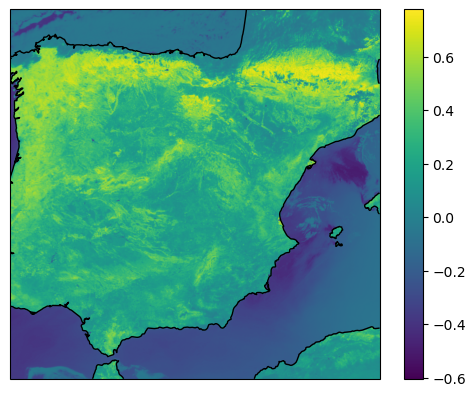

In [20]:
ndvidata = newscn["ndvi"].chunk({'y': 512, 'x': 512})
ndvi=ndvidata.data.compute()
#ndvi = newscn["ndvi"].data.compute()

result = resample_nearest(swath_def, ndvi, area_def, radius_of_influence=20000, fill_value=None)

#cartopy
crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw=dict(projection=crs))
coastlines = ax.coastlines()  
ax.set_global()

#plot
img = plt.imshow(result, transform=crs, extent=crs.bounds, origin='upper')
cbar = plt.colorbar()